In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

We generate 1 million samples from the Gaussian distribution with the model parameters:
1. <b>delta</b> ~ cauchy(0, 1)
2. <b>mu</b> ~ cauchy(0, 1)
3. <b>sigma</b> ~ gamma(2, 2)
4. <b>alpha</b> = delta * sigma
5. <b>x</b> ~ normal(mu+alpha, sigma)
6. <b>y</b> ~ normal(mu, sigma)

In [88]:
num_points = 10000     # [100, 10000, 1000000]

In [89]:
def generate_data_normal(N):
    delta = np.random.standard_cauchy(1)
    mu = np.random.standard_cauchy(1)
    sigma = np.random.gamma(2, 2, 1)
    alpha = delta * sigma
    
    xdata = np.random.normal(mu+alpha, sigma, N)
    ydata = np.random.normal(mu, sigma, N)
    return (xdata, ydata)

In [90]:
def plot_data_hist(x, y):
    plt.figure(figsize=(10,5))
    plt.hist(x, alpha=0.5, bins=500, label="X data")
    plt.hist(y, alpha=0.5, bins=500, label="Y data")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()
    
def plot_trace_hist(trace):
    plt.hist(trace, alpha=0.5, bins=500, label="delta")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

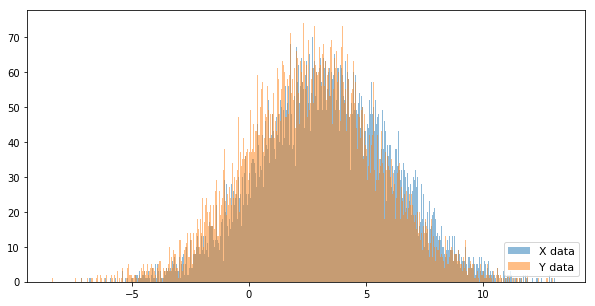

In [91]:
np.random.seed(33)
xdata, ydata = generate_data_normal(num_points)
plot_data_hist(xdata, ydata)

# PyStan

The PyStan project is the official Python wrapper of the Stan Probabilistic programming language, which is implemented in C++.

In [92]:
import pystan
pystan.__version__

'2.15.0.0'

In [93]:
# Create the Stan model
fit_code = """
data {
	int<lower=0> N; 	// number of entities
	real y[N]; 		// normally distributed KPI in the control group
	real x[N]; 		// normally distributed KPI in the treatment group
}

parameters {
	real mu;			// population mean
	real<lower=0> sigma;// population variance
	real delta;
}

transformed parameters {
	real alpha;			// total effect size
	alpha = delta * sigma;
}

model {
	delta ~ cauchy(0, 1);
	mu ~ cauchy(0, 1);
	sigma ~ gamma(2, 2);
	x ~ normal(mu+alpha, sigma);
	y ~ normal(mu, sigma);
}
"""
fit_data = {'N': num_points, 'x': xdata, 'y': ydata}

Sampling in Stan uses a No U-Turn Sampler, which is more sophisticated than classic Metropolis-Hastings or Gibbs sampling.

In [94]:
import time
start_time = time.time()

# perform the fit
fit = pystan.stan(model_code=fit_code, data=fit_data, iter=25000, chains=4)
# extract the traces
traces = fit.extract()
pystan_mcmc_trace = traces['delta']

end_time = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b2d45a7d585903714f857946572d3df0 NOW.


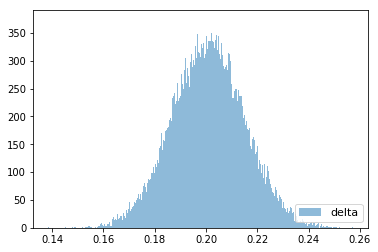

--- pystan mcmc 88.67490124702454 seconds ---


In [95]:
plot_trace_hist(pystan_mcmc_trace)
print("--- pystan mcmc %s seconds ---" % (end_time - start_time))

Variational inference is a scalable technique for approximate Bayesian inference. Variational inference in Stan  implements automatic differentiation variational inference (ADVI). The user only provides a Bayesian model and a dataset; nothing else. The algorithm automatically determines an appropriate variational family and optimizes the variational objective.

In [96]:
from pystan import StanModel
start_time = time.time()

stan_model = StanModel(model_code=fit_code)
results = stan_model.vb(data=fit_data)
pystan_vi_trace = results['sampler_params'][2]

end_time = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b2d45a7d585903714f857946572d3df0 NOW.


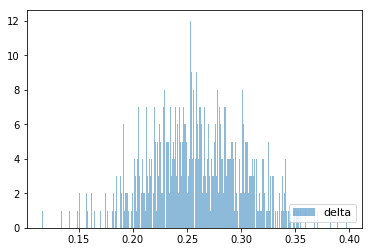

--- pystan vi 62.566168785095215 seconds ---


In [97]:
plot_trace_hist(pystan_vi_trace)
print("--- pystan vi %s seconds ---" % (end_time - start_time))

# PyMC